# Advanced techniques

Let's explore feature engineering techniques with the house prices dataset from Kaggle.

We can find an illustrative example of how to use Deep feature synthesis [here](https://www.kaggle.com/willkoehrsen/featuretools-for-good), and a good explanation [here](https://stackoverflow.com/questions/52418152/featuretools-can-it-be-applied-on-a-single-table-to-generate-features-even-when).

To Do
- Group some features together (business domain)
- Find categories under-represented (beyond current proposed method)
- ~~Scale numerical features~~
- Onehot/Label binarize encode categorical features (option)
- Baseline the model with a multiple linear regression and high degree polynomials

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Advanced-techniques" data-toc-modified-id="Advanced-techniques-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Advanced techniques</a></span><ul class="toc-item"><li><span><a href="#Setup-the-dataset" data-toc-modified-id="Setup-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup the dataset</a></span><ul class="toc-item"><li><span><a href="#Scale-numerical-features" data-toc-modified-id="Scale-numerical-features-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Scale numerical features</a></span></li><li><span><a href="#Check-skewness" data-toc-modified-id="Check-skewness-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Check skewness</a></span></li><li><span><a href="#Check-correlation" data-toc-modified-id="Check-correlation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Check correlation</a></span></li><li><span><a href="#Under-represented-features" data-toc-modified-id="Under-represented-features-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Under represented features</a></span></li><li><span><a href="#OneHot-encoding-for-categorical-variables." data-toc-modified-id="OneHot-encoding-for-categorical-variables.-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>OneHot encoding for categorical variables.</a></span></li><li><span><a href="#Baseline-basic-all-numeric-features" data-toc-modified-id="Baseline-basic-all-numeric-features-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Baseline basic all-numeric features</a></span></li></ul></li><li><span><a href="#Deep-Feature-Synthesis" data-toc-modified-id="Deep-Feature-Synthesis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Deep Feature Synthesis</a></span><ul class="toc-item"><li><span><a href="#Build-the-EntitySet" data-toc-modified-id="Build-the-EntitySet-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Build the EntitySet</a></span></li><li><span><a href="#Normalize-the-entity" data-toc-modified-id="Normalize-the-entity-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Normalize the entity</a></span></li><li><span><a href="#Deep-feature-synthesis" data-toc-modified-id="Deep-feature-synthesis-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Deep feature synthesis</a></span></li></ul></li></ul></li></ul></div>

## Setup the dataset

In [46]:
import nbimporter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import warnings

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, \
        validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from src.dataset import Dataset

In [2]:
houses = Dataset('./data/houseprices_prepared.csv.gz')
houses.describe()


Available types: [dtype('int64') dtype('O') dtype('float64')]
80 Features
43 categorical features
37 numerical features
16 categorical features with NAs
0 numerical features with NAs
64 Complete features
--
Target: Not set


We will replace the NA's in the dataset with 'None' or 'Unknown' since they're not really NA's. For no good reason the person in charge of encoding the file decided to assign NA's to values where the feature does not apply, but instead of using a value for that special condition (like the string 'None') he/she decided to use the actual NA.

In [3]:
houses.replace_na(column='Electrical', value='Unknown')
houses.replace_na(column=houses.names('categorical_na'), value='None')
houses.set_target('SalePrice')
houses.describe()


Available types: [dtype('int64') dtype('O') dtype('float64')]
79 Features
43 categorical features
36 numerical features
0 categorical features with NAs
0 numerical features with NAs
79 Complete features
--
Target: SalePrice


### Scale numerical features

Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [4]:
houses.scale()
houses.describe()


Available types: [dtype('float64') dtype('O')]
79 Features
43 categorical features
36 numerical features
0 categorical features with NAs
0 numerical features with NAs
79 Complete features
--
Target: SalePrice


### Check skewness

In many modeling scenarios, normality of the features in a dataset is desirable. Power transforms are a family of parametric, monotonic transformations that aim to map data from any distribution to as close to a Gaussian distribution as possible in order to stabilize variance and minimize skewness.

In [5]:
houses.ensure_normality()
houses.describe()


Available types: [dtype('float64') dtype('O')]
79 Features
43 categorical features
36 numerical features
0 categorical features with NAs
0 numerical features with NAs
79 Complete features
--
Target: SalePrice


### Check correlation

In [6]:
numericals_to_drop, corr_num = houses.numerical_correlated(threshold=0.7)
print('There are {} correlated columns to remove.'.format(
    len(numericals_to_drop)))
print(numericals_to_drop)
# houses.plot_corr_matrix(corr_num)

There are 3 correlated columns to remove.
['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


In [7]:
categoricals_to_drop, corr_categ = houses.categorical_correlated(threshold=0.7)
print('There are {} correlated columns to remove.'.format(
    len(categoricals_to_drop)))
print(categoricals_to_drop)
# houses.plot_corr_matrix(corr_categ)

There are 2 correlated columns to remove.
['Exterior2nd', 'GarageCond']


In [8]:
houses.drop_columns(categoricals_to_drop + numericals_to_drop)
houses.describe()


Available types: [dtype('float64') dtype('O')]
74 Features
41 categorical features
33 numerical features
0 categorical features with NAs
0 numerical features with NAs
74 Complete features
--
Target: SalePrice


### Under represented features

In [9]:
urf = houses.under_represented_features()
print('Features with unrepresented categories:\n', urf)
houses.drop_columns(urf)
print(end='')
houses.describe();

Features with unrepresented categories:
 ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'PoolQC']

Available types: [dtype('float64') dtype('O')]
69 Features
36 categorical features
33 numerical features
0 categorical features with NAs
0 numerical features with NAs
69 Complete features
--
Target: SalePrice


### OneHot encoding for categorical variables.

Convert categorical variable into dummy/indicator variables. I use pandas `get_dummies` for this task. Beware of not using this before measuring correlation, as it will destroy your measurements.

In [10]:
houses.onehot_encode()
houses.describe()


Available types: [dtype('float64') dtype('uint8')]
254 Features
0 categorical features
254 numerical features
0 categorical features with NAs
0 numerical features with NAs
254 Complete features
--
Target: SalePrice


### Baseline basic all-numeric features

Time to assess what can a simple and multiple linear regression can do.

In [12]:
X, y = houses.split(test_size=0.2)

Obtained 22 positive R2 scores
Best Validation R2: 0.89
Avg. Validation R2: 0.78


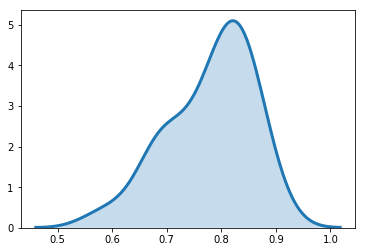

In [28]:
model = LinearRegression()
cv = ShuffleSplit(n_splits=1000, test_size=0.2, random_state=666)
scores = cross_val_score(model, 
                         X.train, y.train, 
                         cv=cv, 
                         scoring='r2')
print('Obtained {} positive R2 scores'.format(len(scores[scores > 0.0])))
print('Best Validation R2: {:.2f}'.format(max(scores)))
print('Avg. Validation R2: {:.2f}'.format(np.mean(scores[scores > 0.0])))

sns.distplot(scores[scores > 0.0], hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3});

It seems that we can evaluate our regression problem using CV, but with a 1'st degree polynomial which is clearly too simple for this problem. The symptom of this is the extremely negative values of the R2 scores obtained.

To improve our solution, let's build a linear regression model with a higher degree polynomial. To do so, a scikit learn pipeline is used, where PolynomialFeatures is used before the linear regression, to try out different `degree` polynomials.

`PolynomialFeatures` generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [42]:
def polynomial_pipeline(X, y, cv, degree):
    """
    Build a pipeline with polinomial expressions and linear regression over it.
    """
    poly = PolynomialFeatures(degree=degree, interaction_only=False, 
                              include_bias=False)
    lm = LinearRegression()
    pipeline = make_pipeline(poly, lm)
    return pipeline.fit(X, y)

In [43]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=666)
pipeline = polynomial_pipeline(X.train, y.train, cv, degree=2)
scores = cross_val_score(pipeline, X.test, y.test,
                         scoring="r2", cv=cv)

print('Obtained {} positive R2 scores'.format(len(scores[scores > 0.0])))
print('Best Validation R2: {:.2f}'.format(max(scores)))
print('Avg. Validation R2: {:.2f}'.format(np.mean(scores[scores > 0.0])))

Obtained 100 positive R2 scores
Best Validation R2: 0.95
Avg. Validation R2: 0.89


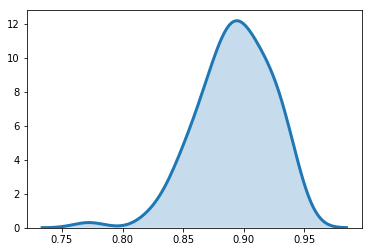

In [44]:
sns.distplot(scores[scores > 0.0], hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3});

Check now what is the perfect degree for the polynomial.

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=555)
model = make_pipeline(PolynomialFeatures(), LinearRegression())
train_scores, validation_scores = validation_curve(
                 model, X.train, y.train,
                 param_name='polynomialfeatures__degree',
                 cv=cv,
                 param_range=np.arange(1, 10))
plot_validation_curve()

## Deep Feature Synthesis
### Build the EntitySet

In [ ]:
import featuretools as ft

es = ft.EntitySet()
es = es.entity_from_dataframe(entity_id='houses', 
                              dataframe=houses.features,
                              index = 'Id')
es

### Normalize the entity

In [ ]:
es.normalize_entity(base_entity_id='houses', 
                    new_entity_id='houses_norm',
                    additional_variables = houses.names('all').remove('Id'),
                    index='Id')
es

### Deep feature synthesis

In [ ]:
f_matrix, f_defs = ft.dfs(entityset=es,
                          target_entity='houses_norm', 
                          n_jobs=-1)

Remove new variables that might be related to the target

In [ ]:
drop_cols = []
for col in f_matrix:
    if col == houses.target.name:
        pass
    else:
        if houses.target.name in col:
            drop_cols.append(col)
            
print('Need to drop columns:', drop_cols)
f_matrix = f_matrix[[x for x in f_matrix if x not in drop_cols]]

In [ ]:
f_matrix.shape